In [3]:
import numpy as np
import pandas as pd
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

In [4]:
# import the csv file
df = pd.read_csv('2020_ffl_df.csv')

# clean up the kde_icdf column
for i in range(0,len(df)):
    df['kde_icdf'][i] = df['kde_icdf'][i].replace('\n',' ').replace('[','').replace(']','')
    df['kde_icdf'][i] = [float(x) for x in df['kde_icdf'][i].split()]
    
# more data cleanup
df['POS']=df['POS'].str.strip()

# add drafted column to track drafted players
df['drafted']=0

In [10]:
def DAsHa_prgm(ttnp):
    # variable for 'turns to next pick'
    # ttnp = 24

    #to find current draft number
    cur_num = 0
    i = 0
    while cur_num == 0:
        if df['drafted'][i] == 1:
            i += 1
        else:
            cur_num = df['Draft Position'][i]

    # threshold for next available picks
    next_avail = cur_num+ttnp

    # loops to construct info panes
    # set up vars
    compare1 = [] # to collect best players at each position
    compare2 = [] # to collect best available next round at each position (note: may overlap with compare1)
    compare3 = [] # to collect second-best player at each position

    positions = ['QB','RB','WR','TE','K','DEF']

    # loop to identify best choices
    j = 0
    for j in range(0, len(positions)):
        k = 0
        for k in range(0, len(df)):
            if df['drafted'][k] == 1:
                k += 1
            if df['drafted'][k] == 0:
                if df['POS'][k] == positions[j]:
                    if len(compare1) > j:
                        if df['pts'][k] > compare1[j][2]:
                            compare1[j] = [df['POS'][k], df['Name'][k], df['pts'][k], df['Draft Position'][k]]
                            k += 1
                        if df['pts'][k] <= compare1[j][2]:
                            k += 1
                    if len(compare1)<=j:
                        compare1.append([df['POS'][k], df['Name'][k], df['pts'][k],df['Draft Position'][k]])
                        k += 1

    # loop to identify best choice in next round at each position                
    j = 0
    for j in range(0, len(positions)):
        k = 0
        for k in range(0, len(df)):
            if df['drafted'][k] == 1:
                k += 1
            if df['drafted'][k] == 0:
                if df['POS'][k] == positions[j]:
                    if len(compare2) > j:
                        if df['Draft Position'][k] < next_avail:
                            k += 1
                        else:
                            if df['pts'][k] > compare2[j][2]:
                                compare2[j] = [df['POS'][k], df['Name'][k], df['pts'][k], df['Draft Position'][k]]
                                k += 1
                            if df['pts'][k] <= compare2[j][2]:
                                k += 1
                    if len(compare2)<=j:
                        if df['Draft Position'][k] < next_avail:
                            k += 1
                        else:
                            compare2.append([df['POS'][k], df['Name'][k], df['pts'][k], df['Draft Position'][k]])
                            k += 1 

    # loop to collect second-best choices for each round
    j = 0
    for j in range(0,len(positions)):
        k = 0
        for k in range(0,len(df)):
            if df['drafted'][k] == 1:
                k += 1
            if df['drafted'][k] == 0:
                if df['POS'][k] == positions[j]:
                    if len(compare3) > j:
                        if df['Name'][k] == compare1[j][1]:
                            k += 1
                        else:
                            if df['pts'][k] > compare3[j][2]:
                                compare3[j]=[df['POS'][k], df['Name'][k], df['pts'][k], df['Draft Position'][k]]
                                k += 1
                            if df['pts'][k] <= compare3[j][2]:
                                k += 1
                    if len(compare3)<=j:
                        if df['Name'][k] == compare1[j][1]:
                            k += 1
                        else:
                            compare3.append([df['POS'][k], df['Name'][k], df['pts'][k], df['Draft Position'][k]])
                            k += 1 

    # make marginal comparison and append to compare1 list
    for j in range(0,len(positions)):
        marg = compare1[j][2] - compare2[j][2]
        compare1[j].append(marg)

    # print recommendation menu
    for i in range(0,len(positions)):
        print(f"{compare1[i][0]:{5}} - {compare1[i][1]:{20}} - {round(compare1[i][2],2):{6}}, margin: {round(compare1[i][4],2)}")

    # find top two second-best
    top_seconds = [compare3[0][2], compare3[1][2], compare3[2][2], compare3[3][2], compare3[4][2], compare3[5][2],]

    # finding index values (based off Yahoo! draft position) to call the boxplots
    f = compare1[0][3] - 1
    e = compare1[1][3] - 1
    d = compare1[2][3] - 1
    c = compare1[3][3] - 1
    b = compare1[4][3] - 1
    a = compare1[5][3] - 1

    # boxplots of recs
    box_plot_data=[df['kde_icdf'][a], df['kde_icdf'][b], df['kde_icdf'][c], df['kde_icdf'][d], df['kde_icdf'][e], df['kde_icdf'][f]]
    plt.boxplot(box_plot_data, vert=False, labels=[df['Name'][a], df['Name'][b], df['Name'][c], df['Name'][d], df['Name'][e], df['Name'][f] ])
    plt.show()

    # find top two second-best
    top_seconds = [compare3[0][2], compare3[1][2], compare3[2][2], compare3[3][2],compare3[4][2],compare3[5][2],]

    first_comp = top_seconds.index(max(top_seconds))
    top_seconds[first_comp] = 0
    second_comp = top_seconds.index(max(top_seconds))

    # boxplots of second best
    z = compare1[first_comp][3] - 1
    y = compare3[first_comp][3] - 1
    x = compare1[second_comp][3] - 1
    w = compare3[second_comp][3] - 1

    box_plot_data=[df['kde_icdf'][y], df['kde_icdf'][z]]
    plt.boxplot(box_plot_data, vert=False, labels=[df['Name'][y], df['Name'][z]])
    plt.show()

    box_plot_data=[df['kde_icdf'][w], df['kde_icdf'][x]]
    plt.boxplot(box_plot_data, vert=False, labels=[df['Name'][w], df['Name'][x]])
    plt.show()   

In [11]:
### This is the user-interace: enter the picked players until it's your turn. Then, enter "DAsHA_prgm(# of rounds to your next pick)" in the cell below.


In [36]:
your_turn = 'No'
while your_turn == 'No':
    new_draft = input('Who was the last pick?')
    if new_draft != '':
        temp_index = df['Name'].str.find(str(new_draft.strip()))
        temp_no = temp_index.values.argmax()
        df['drafted'][temp_no] = 1
        new_draft = ''
    your_turn = input('Is it your turn?')
    if your_turn == 'no':
        your_turn = 'No'
    elif your_turn == 'n':
        your_turn = 'No'
    elif your_turn == 'No.':
        your_turn = 'No'


QB    - Matt Ryan            - 303.99, margin: 26.46
RB    - Leonard Fournette    - 208.47, margin: 0.0
WR    - A.J. Brown           - 184.65, margin: 0.0
TE    - Jared Cook           - 130.62, margin: 0.0
K     - Harrison Butker      - 153.07, margin: 0.0
DEF   - New England          -  180.3, margin: 0.0


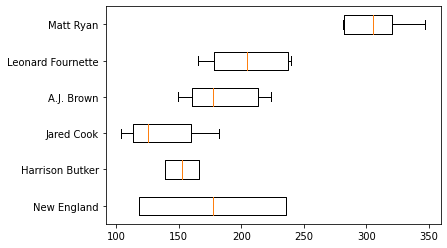

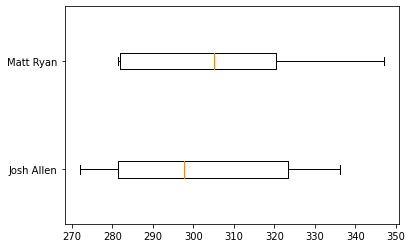

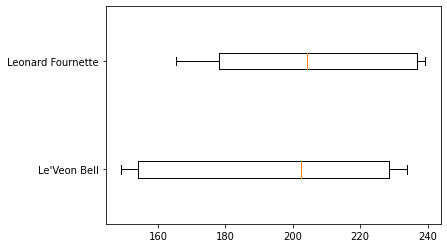

In [37]:
DAsHa_prgm(14)